In [0]:
# Requires
# - pycryptodome (pycrypto for 3.6)
# - numpy /scipy / matplotlib
# - pandas

In [0]:
import hashlib
import random
import string
import json
import binascii
import numpy as np
import pandas as pd
import pylab as pl
import logging
%matplotlib inline

In [0]:
def sha256(message):
    return hashlib.sha256(message.encode('ascii')).hexdigest()

In [33]:
message = 'hello bitcoin'
for nonce in range(1000):
    digest = sha256(message + str(nonce))
    if digest.startswith('11'):
        print('Found nonce = %d' % nonce)
        break
print(sha256(message + str(nonce)))

Found nonce = 32
112c38d2fdb6ddaf32f371a390307ccc779cd92443b42c4b5c58fa548f63ed83


In [0]:
def dumb_hash(message):
    """
    Returns an hexadecimal hash
    """
    return sha256(message)


def mine(message, difficulty=1):
    """
    Given an input string, will return a nonce such that
    hash(string + nonce) starts with `difficulty` ones
    
    Returns: (nonce, niters)
        nonce: The found nonce
        niters: The number of iterations required to find the nonce
    """
    assert difficulty >= 1, "Difficulty of 0 is not possible"
    i = 0
    prefix = '1' * difficulty
    while True:
        nonce = str(i)
        digest = dumb_hash(message + nonce)
        if digest.startswith(prefix):
            return nonce, i
        i += 1

In [35]:
nonce, niters = mine('42', difficulty=1)
print('Took %d iterations' % niters)

nonce, niters = mine('42', difficulty=3)
print('Took %d iterations' % niters)

Took 23 iterations
Took 2272 iterations


In [0]:
def random_string(length=10):
    return ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(length))

strings = [random_string() for i in range(50)]

In [0]:
levels = range(1, 5)
# An array of results with a row for each difficulty and a column for each test string
results = pd.DataFrame(index=strings, columns=levels, dtype=np.int)
results.fillna(value=0)

#results = np.zeros((N_LEVELS, len(strings)), dtype=np.int)
for level in levels:
    for s in strings:
        _, niters = mine(s, difficulty=level)
        results[level][s] = niters

In [38]:
results.iloc[:5]

,1,2,3,4
KAV86UG0OM,7,7,7,3149
2TTT67MNT6,2,118,975,43042
CDAR5XBMHF,4,188,4837,132689
9HHQIF5IBI,12,114,9180,17489
T17L2JNMFE,5,5,2332,270019


Text(0, 0.5, 'Iterations')

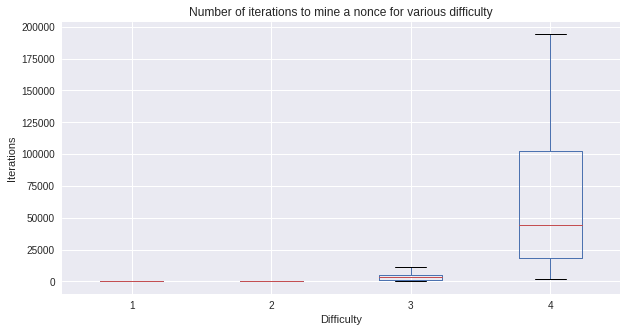

In [39]:
pl.figure(figsize=(10, 5))
ax = pl.subplot(111)
ax.set_title('Number of iterations to mine a nonce for various difficulty')
results.plot.box(showfliers=False, ax=ax)
ax.set_xlabel('Difficulty')
ax.set_ylabel('Iterations')

In [40]:
pip install pycrypto

In [0]:
class TransactionInput(object):
    """
    An input for a transaction. This points to an output of another transaction
    """
    def __init__(self, transaction, output_index):
        self.transaction = transaction
        self.output_index = output_index
        assert 0 <= self.output_index < len(transaction.outputs)
        
    def to_dict(self):
        d = {
            'transaction': self.transaction.hash(),
            'output_index': self.output_index
        }
        return d
    
    @property
    def parent_output(self):
        return self.transaction.outputs[self.output_index]
    

class TransactionOutput(object):
    """
    An output for a transaction. This specifies an amount and a recipient (wallet)
    """
    def __init__(self, recipient_address, amount):
        self.recipient = recipient_address
        self.amount = amount
        
    def to_dict(self):
        d = {
            'recipient_address': self.recipient,
            'amount': self.amount
        }
        return d

        
def compute_fee(inputs, outputs):
    """
    Compute the transaction fee by computing the difference between total input and total output
    """
    total_in = sum(i.transaction.outputs[i.output_index].amount for i in inputs)
    total_out = sum(o.amount for o in outputs)
    assert total_out <= total_in, "Invalid transaction with out(%f) > in(%f)" % (total_out, total_in)
    return total_in - total_out

    
class Transaction(object):
    def __init__(self, wallet, inputs, outputs):
        """
        Create a transaction spending money from the provided wallet
        """
        self.inputs = inputs
        self.outputs = outputs
        self.fee = compute_fee(inputs, outputs)
        self.signature = wallet.sign(json.dumps(self.to_dict(include_signature=False)))
        
    def to_dict(self, include_signature=True):
        d = {
            "inputs": list(map(TransactionInput.to_dict, self.inputs)),
            "outputs": list(map(TransactionOutput.to_dict, self.outputs)),
            "fee": self.fee
        }
        if include_signature:
            d["signature"] = self.signature
        return d
    
    def hash(self):
        return dumb_hash(json.dumps(self.to_dict()))
    
    
class GenesisTransaction(Transaction):
    """
    This is the first transaction which is a special transaction
    with no input and 25 bitcoins output
    """
    def __init__(self, recipient_address, amount=25):
        self.inputs = []
        self.outputs = [
            TransactionOutput(recipient_address, amount)
        ]
        self.fee = 0
        self.signature = 'genesis'
        
    def to_dict(self, include_signature=False):
        # TODO: Instead, should sign genesis transaction will well-known public key ?
        assert not include_signature, "Cannot include signature of genesis transaction"
        return super().to_dict(include_signature=False)

In [0]:
import Crypto
import Crypto.Random
from Crypto.Hash import SHA
from Crypto.PublicKey import RSA
from Crypto.Signature import PKCS1_v1_5


class Wallet(object):
    """
    A wallet is a private/public key pair
    """
    def __init__(self):
        random_gen = Crypto.Random.new().read
        self._private_key = RSA.generate(1024, random_gen)
        self._public_key = self._private_key.publickey()
        self._signer = PKCS1_v1_5.new(self._private_key)
        
    @property
    def address(self):
        """We take a shortcut and say address is public key"""
        return binascii.hexlify(self._public_key.exportKey(format='DER')).decode('ascii')
    
    def sign(self, message):
        """
        Sign a message with this wallet
        """
        h = SHA.new(message.encode('utf8'))
        return binascii.hexlify(self._signer.sign(h)).decode('ascii')
    
    
def verify_signature(wallet_address, message, signature):
    """
    Check that the provided `signature` corresponds to `message`
    signed by the wallet at `wallet_address`
    """
    pubkey = RSA.importKey(binascii.unhexlify(wallet_address))
    verifier = PKCS1_v1_5.new(pubkey)
    h = SHA.new(message.encode('utf8'))
    return verifier.verify(h, binascii.unhexlify(signature))


# Check that the wallet signing functionality works
w1 = Wallet()
signature = w1.sign('foobar')
assert verify_signature(w1.address, 'foobar', signature)
assert not verify_signature(w1.address, 'rogue message', signature)

In [0]:
alice = Wallet()
bob = Wallet()

t1 = GenesisTransaction(alice.address)
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 2.0), TransactionOutput(alice.address, 22.0)]
)
assert np.abs(t2.fee - 1.0) < 1e-5

In [0]:
alice = Wallet()
bob = Wallet()
walter = Wallet()

# This gives 25 coins to Alice
t1 = GenesisTransaction(alice.address)

# Of those 25, Alice will spend
# Alice -- 5 --> Bob
#       -- 15 --> Alice
#       -- 5 --> Walter
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 5.0), TransactionOutput(alice.address, 15.0), TransactionOutput(walter.address, 5.0)]
)

# Walter -- 5 --> Bob
t3 = Transaction(
    walter,
    [TransactionInput(t2, 2)],
    [TransactionOutput(bob.address, 5.0)])

# Bob -- 8 --> Walter
#     -- 1 --> Bob
#        1 fee
t4 = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)

transactions = [t1, t2, t3, t4]


In [45]:
def compute_balance(wallet_address, transactions):
    """
    Given an address and a list of transactions, computes the wallet balance of the address
    """
    balance = 0
    for t in transactions:
        # Subtract all the money that the address sent out
        for txin in t.inputs:
            if txin.parent_output.recipient == wallet_address:
                balance -= txin.parent_output.amount
        # Add all the money received by the address
        for txout in t.outputs:
            if txout.recipient == wallet_address:
                balance += txout.amount
    return balance

print("Alice  has %.02f dumbcoins" % compute_balance(alice.address, transactions))
print("Bob    has %.02f dumbcoins" % compute_balance(bob.address, transactions))
print("Walter has %.02f dumbcoins" % compute_balance(walter.address, transactions))

Alice  has 15.00 dumbcoins
Bob    has 1.00 dumbcoins
Walter has 8.00 dumbcoins


In [0]:
def verify_transaction(transaction):
    """
    Verify that the transaction is valid.
    We need to verify two things :
    - That all of the inputs of the transaction belong to the same wallet
    - That the transaction is signed by the owner of said wallet
    """
    tx_message = json.dumps(transaction.to_dict(include_signature=False))
    if isinstance(transaction, GenesisTransaction):
        # TODO: We should probably be more careful about validating genesis transactions
        return True
    
    # Verify input transactions
    for tx in transaction.inputs:
        if not verify_transaction(tx.transaction):
            logging.error("Invalid parent transaction")
            return False
    
    # Verify a single wallet owns all the inputs
    first_input_address = transaction.inputs[0].parent_output.recipient
    for txin in transaction.inputs[1:]:
        if txin.parent_output.recipient != first_input_address:
            logging.error(
                "Transaction inputs belong to multiple wallets (%s and %s)" %
                (txin.parent_output.recipient, first_input_address)
            )
            return False
    
    if not verify_signature(first_input_address, tx_message, transaction.signature):
        logging.error("Invalid transaction signature, trying to spend someone else's money ?")
        return False
    
    # Call compute_fee here to trigger an assert if output sum is great than input sum. Without this,
    # a miner could put such an invalid transaction.
    compute_fee(transaction.inputs, transaction.outputs)
    
    return True


t1 = GenesisTransaction(alice.address)
# This is an invalid transaction because bob is trying to spend alice's money
# (alice was the recipient of the input - t1)
t2 = Transaction(
    bob,
    [TransactionInput(t1, 0)],
    [TransactionOutput(walter.address, 10.0)]
)
# This is valid, alice is spending her own money
t3 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(walter.address, 10.0)]
)

In [0]:
assert verify_transaction(t1)

In [48]:
assert not verify_transaction(t2)

ERROR:root:Invalid transaction signature, trying to spend someone else's money ?


In [0]:
assert verify_transaction(t3)

In [0]:
BLOCK_INCENTIVE = 25 # The number of coins miners get for mining a block
DIFFICULTY = 2


def compute_total_fee(transactions):
    """Return the total fee for the set of transactions"""
    return sum(t.fee for t in transactions)


class Block(object):
    def __init__(self, transactions, ancestor, miner_address, skip_verif=False):
        """
        Args:
            transactions: The list of transactions to include in the block
            ancestor: The previous block
            miner_address: The address of the miner's wallet. This is where the block
                           incentive and the transactions fees will be deposited
        """
        reward = compute_total_fee(transactions) + BLOCK_INCENTIVE
        self.transactions = [GenesisTransaction(miner_address, amount=reward)] + transactions
        self.ancestor = ancestor
        
        if not skip_verif:
            assert all(map(verify_transaction, transactions))
        
        json_block = json.dumps(self.to_dict(include_hash=False))
        self.nonce, _ = mine(json_block, DIFFICULTY)
        self.hash = dumb_hash(json_block + self.nonce)
        
    def fee(self):
        """Return transaction fee for this block"""
        return compute_total_fee(self.transactions)
    
    def to_dict(self, include_hash=True):
        d = {
            "transactions": list(map(Transaction.to_dict, self.transactions)),
            "previous_block": self.ancestor.hash,
        }
        if include_hash:
            d["nonce"] = self.nonce
            d["hash"] = self.hash
        return d
    
    
class GenesisBlock(Block):
    """
    The genesis block is the first block in the chain.
    It is the only block with no ancestor
    """
    def __init__(self, miner_address):
        super(GenesisBlock, self).__init__(transactions=[], ancestor=None, miner_address=miner_address)

    def to_dict(self, include_hash=True):
        d = {
            "transactions": [],
            "genesis_block": True,
        }
        if include_hash:
            d["nonce"] = self.nonce
            d["hash"] = self.hash
        return d

In [0]:
def verify_block(block, genesis_block, used_outputs=None):
    """
    Verifies that a block is valid :
    - Verifies the hash starts with the required amount of ones
    - Verifies that the same transaction output isn't used twice
    - Verifies all transactions are valid
    - Verifies the first transaction in the block is a genesis transaction with BLOCK_INCENTIVE + total_fee
    
    Args:
        block: The block to validate
        genesis_block: The genesis block (this needs to be shared by everybody. E.g. hardcoded somewhere)
        used_outputs: list of outputs used in transactions for all blocks above this one
    """
    if used_outputs is None:
        used_outputs = set()
    
    # Verify hash
    prefix = '1' * DIFFICULTY
    if not block.hash.startswith(prefix):
        logging.error("Block hash (%s) doesn't start with prefix %s" % (block.hash, prefix))
        return False
    if not all(map(verify_transaction, block.transactions)):
        return False
    
    # Verify that transactions in this block don't use already spent outputs
    #
    # Note that we could move this in verify_transaction, but this would require some passing the used_outputs
    # around more. So we do it here for simplicity
    for transaction in block.transactions:
        for i in transaction.inputs:
            if i.parent_output in used_outputs:
                logging.error("Transaction uses an already spent output : %s" % json.dumps(i.parent_output.to_dict()))
                return False
            used_outputs.add(i.parent_output)
    
    # Verify ancestors up to the genesis block
    if not (block.hash == genesis_block.hash):
        if not verify_block(block.ancestor, genesis_block, used_outputs):
            logging.error("Failed to validate ancestor block")
            return False
    
    # Verify the first transaction is the miner's reward
    tx0 = block.transactions[0]
    if not isinstance(tx0, GenesisTransaction):
        logging.error("Transaction 0 is not a GenesisTransaction")
        return False
    if not len(tx0.outputs) == 1:
        logging.error("Transactions 0 doesn't have exactly 1 output")
        return False
    reward = compute_total_fee(block.transactions[1:]) + BLOCK_INCENTIVE
    if not tx0.outputs[0].amount == reward:
        logging.error("Invalid amount in transaction 0 : %d, expected %d" % (tx0.outputs[0].amount, reward))
        return False
    
    # Only the first transaction shall be a genesis
    for i, tx in enumerate(block.transactions):
        if i == 0:
            if not isinstance(tx, GenesisTransaction):
                logging.error("Non-genesis transaction at index 0")
                return False  
        elif isinstance(tx, GenesisTransaction):
            logging.error("GenesisTransaction (hash=%s) at index %d != 0", tx.hash(), i)
            return False
    return True

In [52]:
alice = Wallet()
bob = Wallet()
walter = Wallet()

genesis_block = GenesisBlock(miner_address=alice.address)
print("genesis_block : " + genesis_block.hash + " with fee=" + str(genesis_block.fee()))

t1 = genesis_block.transactions[0]
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 5.0), TransactionOutput(alice.address, 15.0), TransactionOutput(walter.address, 5.0)]
)
t3 = Transaction(
    walter,
    [TransactionInput(t2, 2)],
    [TransactionOutput(bob.address, 5.0)])

t4 = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)

block1 = Block([t2], ancestor=genesis_block, miner_address=walter.address)
print("block1        : " + block1.hash + " with fee=" + str(block1.fee()))

block2 = Block([t3, t4], ancestor=block1, miner_address=walter.address)
print("block2        : " + block2.hash + " with fee=" + str(block2.fee()))

genesis_block : 1162dce8ffec3acf13ce61109f121922eee8cceeea4784aa9d90dc6ec0e0fa92 with fee=0
block1        : 118171c5c681b26715cb11c0582be65a4ec2275ec094cab7c2227c6426cd3c71 with fee=0.0
block2        : 11a3c751925c6817aac2dfc304a68e13ddc4ef465d9be63dbb059cf13ba1387f with fee=1.0


In [53]:
verify_block(block1, genesis_block)
verify_block(block2, genesis_block)

True

In [54]:
def collect_transactions(block, genesis_block):
    """Recursively collect transactions in `block` and all of its ancestors"""
    # Important : COPY block.transactions
    transactions = [] + block.transactions
    if block.hash != genesis_block.hash:
        transactions += collect_transactions(block.ancestor, genesis_block)
    return transactions

transactions = collect_transactions(block2, genesis_block)

# Alice mined 25 (from the genesis block) and gave 5 to bob and 5 to walter
print("Alice  has %.02f dumbcoins" % compute_balance(alice.address, transactions))
# Bob received 5 from alice and 5 from walter, but then back 8 to walter with a transaction fee of 1
print("Bob    has %.02f dumbcoins" % compute_balance(bob.address, transactions))
# Walter mined 2 blocks (2 * 25), received 8 from bob and go a transaction fee of 1 on block2
print("Walter has %.02f dumbcoins" % compute_balance(walter.address, transactions))

Alice  has 15.00 dumbcoins
Bob    has 1.00 dumbcoins
Walter has 59.00 dumbcoins


In [55]:
tx = Transaction(
    walter,
    [TransactionInput(t4, 1)],
    [TransactionOutput(walter.address, 1.0)],
)

# Note that we have to use skip_verif=True to not trigger the assert in Block's constructor
block = Block([tx], ancestor=block2, miner_address=walter.address, skip_verif=True)
assert not verify_block(block, genesis_block)

ERROR:root:Invalid transaction signature, trying to spend someone else's money ?


In [56]:
# This is a transaction signed by bob
tx = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)
# And modified by the miner
tx.outputs[0].amount += 4
block = Block([t3, tx], ancestor=block1, miner_address=walter.address, skip_verif=True)
assert not verify_block(block, genesis_block)

ERROR:root:Invalid transaction signature, trying to spend someone else's money ?


In [57]:
block = Block([t3, t3, t4], ancestor=block1, miner_address=bob.address, skip_verif=True)
assert not verify_block(block, genesis_block)

ERROR:root:Transaction uses an already spent output : {"recipient_address": "30819f300d06092a864886f70d010101050003818d0030818902818100d172f8a86d97db9eb94e5df845ce5e2ebab02ed7f9d6cba61c9ce642e63fea89aa9fdd5a1e116675197f305bd1dadc24b7a86299ee0a0060d02b70b80b3fc08e641d43b0c8216dcbb3a0bdc5b413ea4387890298d2e29e24e3dff5718d1254898d0634f7203d9245a2dd499f3e58f96d85eb9b410aff0380e79270330f37ed6d0203010001", "amount": 5.0}


In [0]:
# Let's start again with the same example transactions and blocks as above
alice = Wallet()
bob = Wallet()
walter = Wallet()

genesis_block = GenesisBlock(miner_address=alice.address)

t1 = genesis_block.transactions[0]
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 5.0), TransactionOutput(alice.address, 15.0), TransactionOutput(walter.address, 5.0)]
)
t3 = Transaction(
    walter,
    [TransactionInput(t2, 2)],
    [TransactionOutput(bob.address, 5.0)])

t4 = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)

block1 = Block([t2], ancestor=genesis_block, miner_address=walter.address)
block2 = Block([t3, t4], ancestor=block1, miner_address=walter.address)

In [59]:
t4_malicious = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(bob.address, 8.0), TransactionOutput(bob.address, 1.0)]
)
block2_malicious = Block([t3, t4_malicious], ancestor=block1, miner_address=bob.address)
print(verify_block(block2_malicious, genesis_block))

True


In [0]:
t6 = Transaction(
    alice,
    [TransactionInput(t2, 1)],
    [TransactionOutput(walter.address, 5.0), TransactionOutput(alice.address, 10.0)]
)

block3_malicious = Block([t6], ancestor=block2_malicious, miner_address=bob.address)

In [61]:
def chain_length(block):
    if block.ancestor is None:
        return 1
    else:
        return 1 + chain_length(block.ancestor)

print("Chain length for block2           : %d" % chain_length(block2))
print("Chain length for block3_malicious : %d " % chain_length(block3_malicious))

Chain length for block2           : 3
Chain length for block3_malicious : 4 
